In [1]:
# CORE IMPORTS
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML / Preprocessing / Metrics
from sklearn.model_selection import (train_test_split , StratifiedKFold, cross_val_predict,cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report,precision_recall_curve,auc)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

# Calibration and utilities
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone
import shap
import joblib
import gradio as gr

sns.set_style("whitegrid")
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
os.makedirs("figures",exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [2]:
df=pd.read_csv("/content/Fraud_Analysis_Dataset.csv")

In [3]:
print("Shape: " ,df.shape)

Shape:  (11142, 10)


In [4]:
df.head()



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [5]:
print('Missing Values : \n', df.isnull().sum())

Missing Values : 
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64


In [6]:
print('Fraud Ratio:- ',df['isFraud'].mean())

Fraud Ratio:-  0.10249506372285047


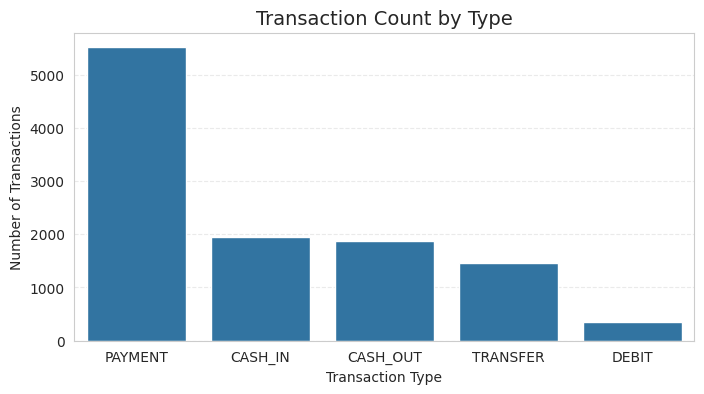

In [7]:
# BEFORE EDA
plt.figure(figsize=(8,4))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title("Transaction Count by Type", fontsize=14)
plt.xlabel("Transaction Type"); plt.ylabel("Number of Transactions")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("figures/count_by_type.png", dpi=200, bbox_inches='tight')
plt.show()


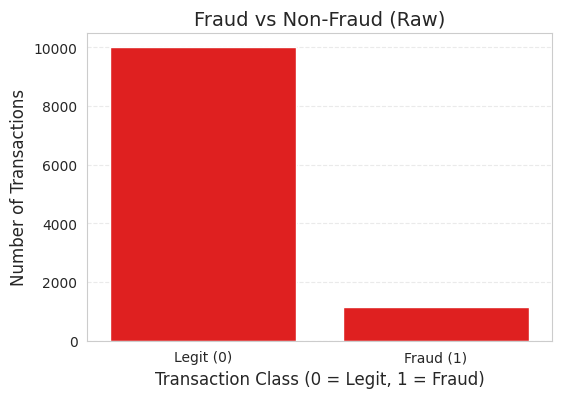

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df , color='red')
plt.title("Fraud vs Non-Fraud (Raw)", fontsize=14)
plt.xlabel("Transaction Class (0 = Legit, 1 = Fraud)", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.xticks([0,1], ['Legit (0)', 'Fraud (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("figures/01_fraud_count.png", dpi=200, bbox_inches='tight')
plt.show()

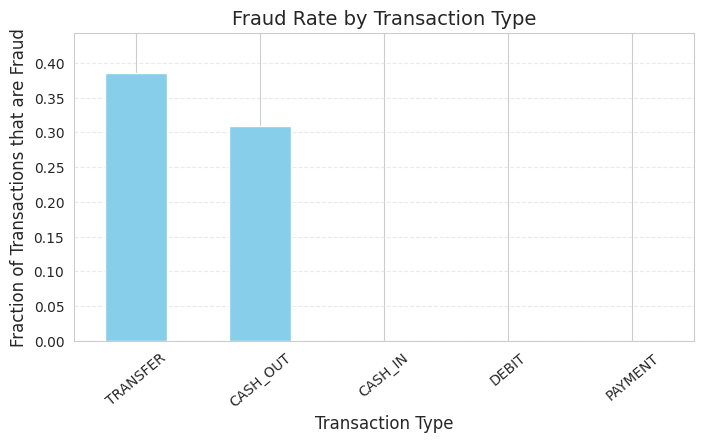

In [9]:
plt.figure(figsize=(8,4))
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', color='skyblue')
plt.title("Fraud Rate by Transaction Type", fontsize=14)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Fraction of Transactions that are Fraud", fontsize=12)
plt.xticks(rotation=40)
plt.ylim(0, fraud_by_type.max() * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("figures/02_fraud_by_type.png", dpi=200, bbox_inches='tight')
plt.show()


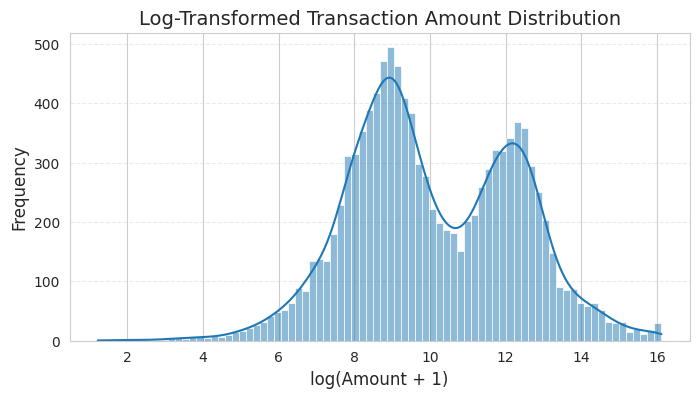

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df['amount']), bins=80, kde=True)
plt.title("Log-Transformed Transaction Amount Distribution", fontsize=14)
plt.xlabel("log(Amount + 1)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("figures/03_log_amount.png", dpi=200, bbox_inches='tight')
plt.show()

In [11]:
df['log_amount']=np.log1p(df['amount'])
df['hour_of_day']=df['step'] % 24

df['frac_orig_spent']=df['amount']/ (df['oldbalanceOrg']+1e-9)
#HERE NEW SPENT IS NOT USED AS THEY BOTH ARE IDENTICAL

df['missing_dest_balance']= (df['oldbalanceDest']== 0).astype(int)
df['is_dest_merchant'] = (df['nameDest'].str.startswith('M')).astype(int)

df['balance_diff_orig'] = df['oldbalanceOrg'] -df ['newbalanceOrig']
df['balance_diff_dest'] = df['newbalanceDest'] -df ['oldbalanceDest']

df['orig_balance_mismatch'] = (
    np.abs(df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']) > 1e-6).astype(int)

df['dest_balance_mismatch'] = (
    np.abs(df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']) > 1e-6).astype(int)

df['is_moving_out'] = (df['oldbalanceOrg'] > df['newbalanceOrig']).astype(int)
df['is_moving_in'] = (df['newbalanceDest'] > df['oldbalanceDest']).astype(int)

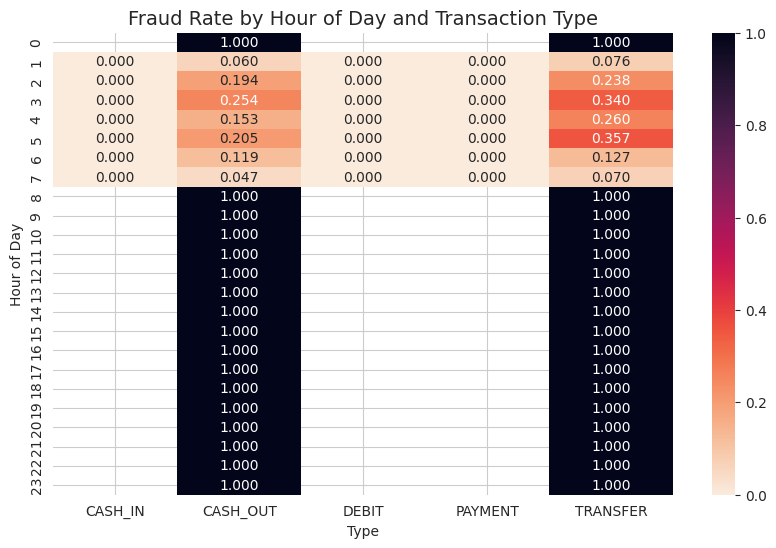

In [12]:
# DURING EDA
pivot = df.pivot_table(index='hour_of_day', columns='type',
                       values='isFraud', aggfunc='mean')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='rocket_r')
plt.title("Fraud Rate by Hour of Day and Transaction Type", fontsize=14)
plt.xlabel("Type"); plt.ylabel("Hour of Day")
plt.savefig("figures/heatmap_hour_vs_type.png", dpi=200, bbox_inches='tight')
plt.show()


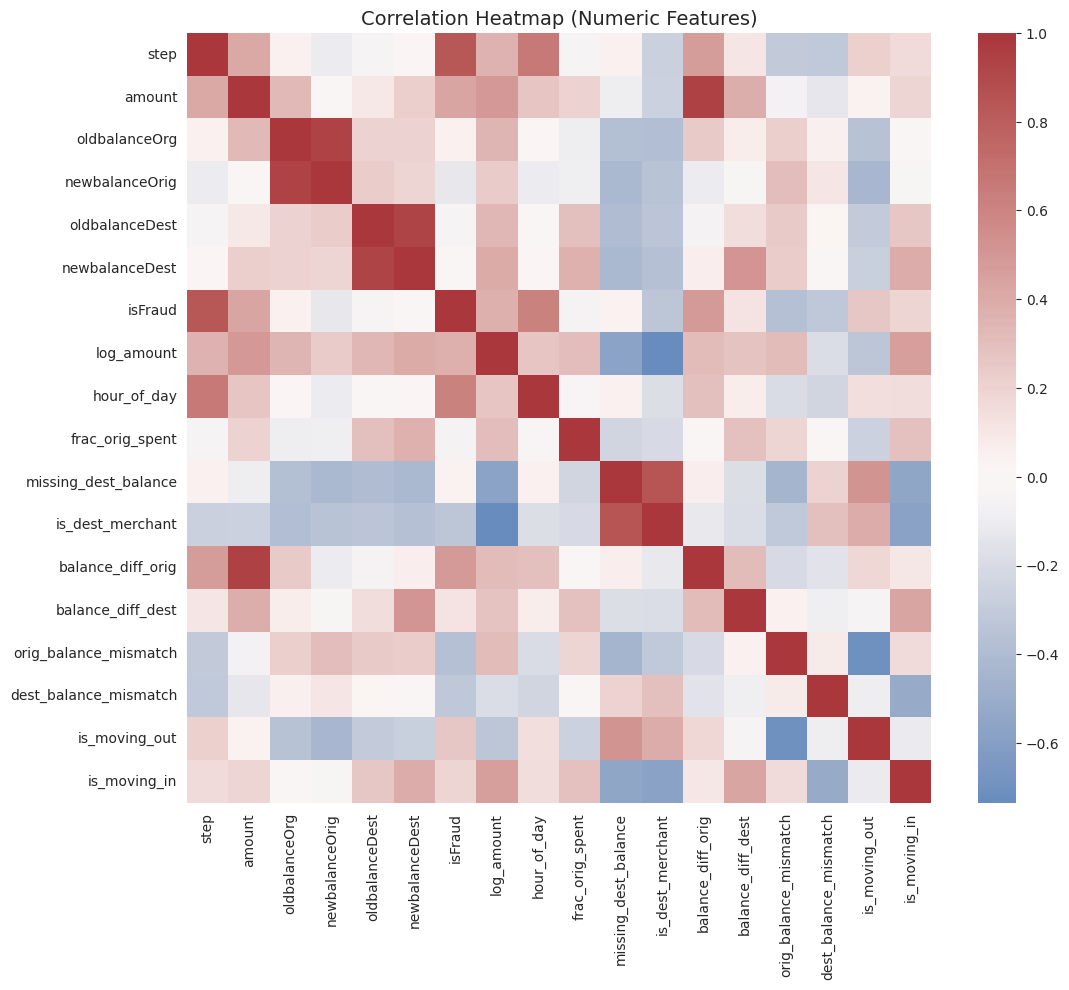

In [13]:
# AFTER FEATURE ENGINEERING, BEFORE MODELING
num = df.select_dtypes(include=np.number)
plt.figure(figsize=(12,10))
sns.heatmap(num.corr(), cmap='vlag', center=0)
plt.title("Correlation Heatmap (Numeric Features)", fontsize=14)
plt.savefig("figures/corr_heatmap.png", dpi=200, bbox_inches='tight')
plt.show()


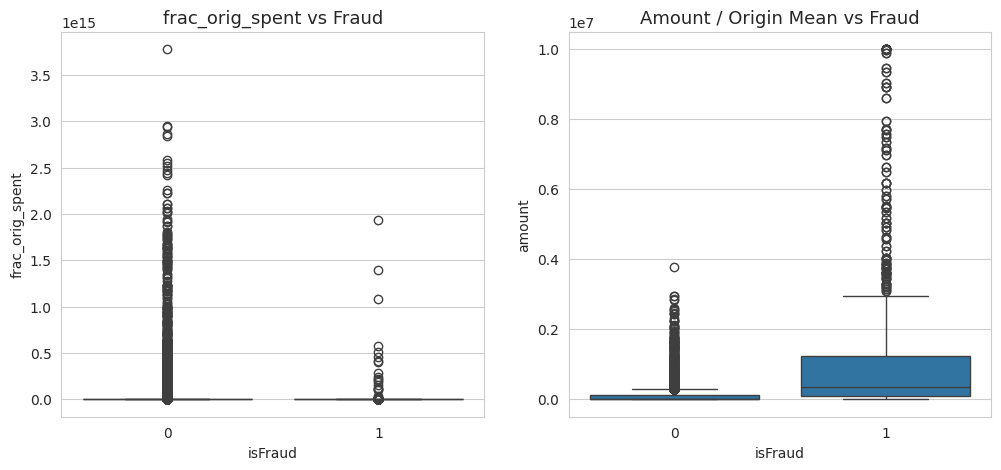

In [14]:
# AFTER FEATURE ENGINEERING
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.boxplot(x='isFraud', y='frac_orig_spent', data=df, ax=ax[0])
ax[0].set_title("frac_orig_spent vs Fraud", fontsize=13)

sns.boxplot(x='isFraud',
            y='amount_over_origin_mean_train' if 'amount_over_origin_mean_train' in df.columns else 'amount',
            data=df, ax=ax[1])
ax[1].set_title("Amount / Origin Mean vs Fraud", fontsize=13)

plt.savefig("figures/engineered_boxplots.png", dpi=200, bbox_inches='tight')
plt.show()


In [15]:
# Separate target and features (keep IDs for aggregation)
y = df['isFraud']
X = df.drop(columns=['isFraud']).copy()

# Split: Test 20%; from remaining 80% use 25% for validation → 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE)

print("Shapes — \nTrain:", X_train.shape,' Val:', X_val.shape ,' Test', X_test.shape)
print("Fraud ratios \nTrain:", y_train.mean(),'  Val: ', y_val.mean(),'  Test: ', y_test.mean())


Shapes — 
Train: (6684, 20)  Val: (2229, 20)  Test (2229, 20)
Fraud ratios 
Train: 0.10248354278874926   Val:  0.10273665320771647   Test:  0.10228802153432032


In [16]:
# Define aggregation column names
agg_cols_dest = [
    'dest_tx_count_train',
    'dest_amount_mean_train',
    'dest_unique_senders_train'
]
agg_cols_orig = [
    'origin_tx_count_train',
    'origin_amount_mean_train',
    'orig_unique_dests_train'
]

# Drop these columns if they already exist safe for re-run
for df_temp in [X_train, X_val, X_test]:
    for col in agg_cols_dest + agg_cols_orig:
        if col in df_temp.columns:
            df_temp.drop(columns=[col], inplace=True)

# Use a clean copy for agg to avoid accidental mutations
train_clean = X_train.copy()

# Train-only DEST aggregation (count, mean)
dest_agg_train = (
    train_clean
    .groupby('nameDest')['amount']
    .agg(['count', 'mean'])
    .rename(columns={'count': 'dest_tx_count_train', 'mean': 'dest_amount_mean_train'})
)

#  Train-only ORIGIN aggregation (count, mean)
orig_agg_train = (
    train_clean
    .groupby('nameOrig')['amount']
    .agg(['count', 'mean'])
    .rename(columns={'count': 'origin_tx_count_train', 'mean': 'origin_amount_mean_train'})
)

# Train-only unique senders / unique dests
dest_unique_senders_train = (
    train_clean
    .groupby('nameDest')['nameOrig']
    .nunique()
    .rename('dest_unique_senders_train')
)
orig_unique_dests_train = (
    train_clean
    .groupby('nameOrig')['nameDest']
    .nunique()
    .rename('orig_unique_dests_train')
)

# Join agg into TRAIN
X_train = X_train.join(dest_agg_train, on='nameDest')
X_train = X_train.join(orig_agg_train, on='nameOrig')
X_train = X_train.join(dest_unique_senders_train, on='nameDest')
X_train = X_train.join(orig_unique_dests_train, on='nameOrig')

# Map train agg into VALIDATION
X_val['dest_tx_count_train'] = X_val['nameDest'].map(dest_agg_train['dest_tx_count_train']).fillna(0)
X_val['dest_amount_mean_train'] = X_val['nameDest'].map(dest_agg_train['dest_amount_mean_train']).fillna(0)
X_val['origin_tx_count_train'] = X_val['nameOrig'].map(orig_agg_train['origin_tx_count_train']).fillna(0)
X_val['origin_amount_mean_train'] = X_val['nameOrig'].map(orig_agg_train['origin_amount_mean_train']).fillna(0)

X_val['dest_unique_senders_train'] = X_val['nameDest'].map(dest_unique_senders_train).fillna(0)
X_val['orig_unique_dests_train']   = X_val['nameOrig'].map(orig_unique_dests_train).fillna(0)

# Map train aggregations into TEST (new/unseen => 0)
X_test['dest_tx_count_train'] = X_test['nameDest'].map(dest_agg_train['dest_tx_count_train']).fillna(0)
X_test['dest_amount_mean_train'] = X_test['nameDest'].map(dest_agg_train['dest_amount_mean_train']).fillna(0)
X_test['origin_tx_count_train'] = X_test['nameOrig'].map(orig_agg_train['origin_tx_count_train']).fillna(0)
X_test['origin_amount_mean_train'] = X_test['nameOrig'].map(orig_agg_train['origin_amount_mean_train']).fillna(0)

X_test['dest_unique_senders_train'] = X_test['nameDest'].map(dest_unique_senders_train).fillna(0)
X_test['orig_unique_dests_train']   = X_test['nameOrig'].map(orig_unique_dests_train).fillna(0)


In [17]:
# Ratio of amount to sender's historical mean
X_train['amount_over_origin_mean_train'] = X_train['amount'] / (X_train['origin_amount_mean_train'] +1e-9)
X_val['amount_over_origin_mean_train'] = X_val['amount'] / (X_val['origin_amount_mean_train'] +1e-9)
X_test['amount_over_origin_mean_train'] = X_test['amount'] / (X_test['origin_amount_mean_train'] +1e-9)

# If any numeric NaNs remain defensively fill with 0
for d in [X_train, X_val, X_test]:
  num_cols =d.select_dtypes(include=np.number).columns
  d[num_cols] = d[num_cols].fillna(0)

In [18]:
feature_cols = [
    'log_amount','hour_of_day','frac_orig_spent','missing_dest_balance','is_dest_merchant',
    'balance_diff_orig','balance_diff_dest','orig_balance_mismatch','dest_balance_mismatch',
    'is_moving_out','is_moving_in',
    'dest_tx_count_train','dest_amount_mean_train','origin_tx_count_train','origin_amount_mean_train',
    'dest_unique_senders_train','orig_unique_dests_train','amount_over_origin_mean_train',
    'type'
]

# Keep only existing features (defensive)
feature_cols = [c for c in feature_cols if c in X_train.columns]

# Build model dataframes and drop raw ID columns if present
X_train_model = X_train[feature_cols].copy()
X_val_model   = X_val[feature_cols].copy()
X_test_model  = X_test[feature_cols].copy()

for d in [X_train_model, X_val_model, X_test_model]:
    for col in ['nameOrig','nameDest']:
        if col in d.columns:
            d.drop(columns=[col], inplace=True)


In [19]:
#Numeric features : all except 'type'
numeric_feats = [c for c in feature_cols if c != 'type']
cat_feats = ['type'] if 'type' in feature_cols else []

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feats),
        ('cat', categorical_transformer, cat_feats)
    ],remainder='drop')

In [20]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8,
                             colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, loss_function='Logloss', verbose=False, random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
for name, model in models.items():
    pipe = Pipeline([('preproc', preprocessor), ('clf', model)])
    ap_scores = cross_val_score(pipe, X_train_model, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
    results.append((name, ap_scores.mean(), ap_scores.std()))
results_df = pd.DataFrame(results, columns=['Model','PR-AUC Mean','PR-AUC Std']).sort_values('PR-AUC Mean', ascending=False)
display(results_df)


,Model,PR-AUC Mean,PR-AUC Std
3,CatBoost,0.998937,0.000217
2,XGBoost,0.998653,0.000320
1,RandomForest,0.998594,0.000496
0,LogisticRegression,0.996232,0.001882


In [21]:
best_model_name = results_df.iloc[0]['Model']
print("Best model selected:", best_model_name)

if best_model_name == 'XGBoost':
    base_clf = XGBClassifier(n_estimators=1000, learning_rate=0.03, max_depth=5,
                             subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
                             eval_metric='logloss', random_state=RANDOM_STATE)
elif best_model_name == 'CatBoost':
 base_clf = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',

    l2_leaf_reg=5,
    random_strength=1,
    subsample=0.8,
    bagging_temperature=0.5,
    rsm=0.85,

    od_type='Iter',
    od_wait=40,

    one_hot_max_size=255,
    random_seed=RANDOM_STATE,
    verbose=False
)
else:

    base_clf = models[best_model_name]

# Fit preprocessor on training data
preprocessor.fit(X_train_model)
X_train_trans = preprocessor.transform(X_train_model)
X_val_trans   = preprocessor.transform(X_val_model)
X_test_trans  = preprocessor.transform(X_test_model)


Best model selected: CatBoost


In [22]:
if best_model_name in ['XGBoost', 'CatBoost']:
    # For XGBoost, early stopping is triggered by eval_set; CatBoost also supports early stopping
    base_clf.fit(X_train_trans, y_train, eval_set=[(X_val_trans, y_val)], verbose=False)
else:
    base_clf.fit(X_train_trans, y_train)


In [23]:
calibrator = CalibratedClassifierCV(estimator=base_clf, method='sigmoid', cv='prefit')
calibrator.fit(X_val_trans, y_val)

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=<catboost.core.CatBoostClassifier object at 0x79e94ef45ac0>)

In [24]:
# OOF probabilities using clone of base_clf inside a pipeline
pipe_oof = Pipeline([('preproc', preprocessor), ('clf', clone(base_clf))])

oof_proba = cross_val_predict(pipe_oof, X_train_model, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:,1]

best_f1 = -1
best_f1_t = 0.5
for t in np.linspace(0,1,101):
    preds = (oof_proba >= t).astype(int)
    f_val = f1_score(y_train, preds)
    if f_val > best_f1:
        best_f1 = f_val
        best_f1_t = t

print("OOF best F1 threshold:", best_f1_t, "F1:", best_f1)


OOF best F1 threshold: 0.51 F1: 0.9824046920821115


In [25]:
# Calibrated probabilities on validation
val_proba = calibrator.predict_proba(X_val_trans)[:,1]

# Business costs (example numbers) — tune these for your scenario
COST_FN = 150000.0   # cost per missed fraud
COST_FP = 500.0      # cost per false positive / investigation

best_cost = float("inf")
best_cost_t = 0.5
thresholds = np.linspace(0,1,201)

for t in thresholds:
    preds = (val_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    total_cost = fn * COST_FN + fp * COST_FP
    if total_cost < best_cost:
        best_cost = total_cost
        best_cost_t = t

print("Validation best cost threshold:", best_cost_t, "Expected cost:", best_cost)


Validation best cost threshold: 0.005 Expected cost: 160000.0


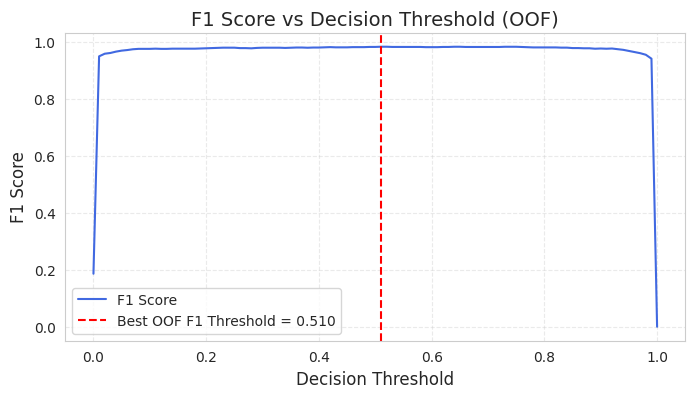

In [26]:
# F1 vs threshold (OOF)
thresholds_f1 = np.linspace(0,1,101)
f1_scores = [f1_score(y_train, (oof_proba >= t).astype(int)) for t in thresholds_f1]

plt.figure(figsize=(8,4))
plt.plot(thresholds_f1, f1_scores, label='F1 Score', color='royalblue')
plt.axvline(best_f1_t, color='red', linestyle='--', label=f'Best OOF F1 Threshold = {best_f1_t:.3f}')
plt.title("F1 Score vs Decision Threshold (OOF)", fontsize=14)
plt.xlabel("Decision Threshold", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("figures/f1_vs_threshold.png", dpi=200, bbox_inches='tight')
plt.show()




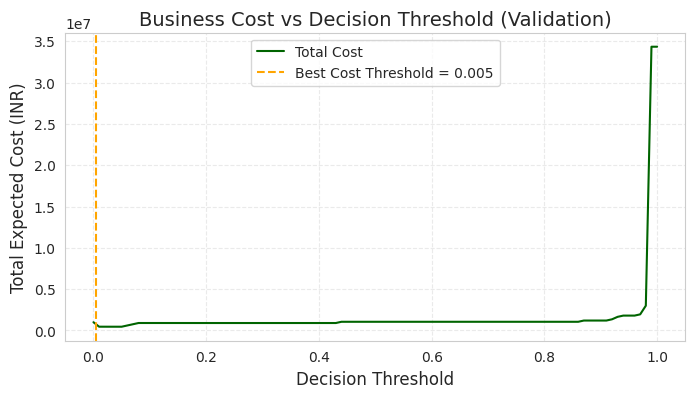

In [27]:
# Cost vs threshold (validation)
thresholds_cost = np.linspace(0,1,101)
costs_val = []
for t in thresholds_cost:
    preds = (val_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    costs_val.append(fn * COST_FN + fp * COST_FP)

plt.figure(figsize=(8,4))
plt.plot(thresholds_cost, costs_val, label='Total Cost', color='darkgreen')
plt.axvline(best_cost_t, color='orange', linestyle='--', label=f'Best Cost Threshold = {best_cost_t:.3f}')
plt.title("Business Cost vs Decision Threshold (Validation)", fontsize=14)
plt.xlabel("Decision Threshold", fontsize=12)
plt.ylabel("Total Expected Cost (INR)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("figures/cost_vs_threshold.png", dpi=200, bbox_inches='tight')
plt.show()

In [28]:
# Only for tree-based models
if best_model_name in ['XGBoost', 'RandomForest']:
    fold_importances = []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X_train_model, y_train), 1):
        X_tr = X_train_model.iloc[tr_idx]; y_tr = y_train.iloc[tr_idx]
        # Fit preprocessor on fold-train so transformation per fold is correct
        preprocessor.fit(X_tr)
        X_tr_t = preprocessor.transform(X_tr)
        # clone base model to isolate fold fit
        m = clone(base_clf)
        m.fit(X_tr_t, y_tr)
        fold_importances.append(m.feature_importances_)

    fold_importances = np.vstack(fold_importances)  # shape: (n_folds, n_features)
    try:
        transformed_names = preprocessor.get_feature_names_out()
    except Exception:
        transformed_names = [f"f{i}" for i in range(fold_importances.shape[1])]

    fi_df = pd.DataFrame({
        'feature': transformed_names,
        'importance_mean': fold_importances.mean(axis=0),
        'importance_std': fold_importances.std(axis=0)
    }).sort_values('importance_mean', ascending=False)

    display(fi_df.head(20))
else:
    print("Feature stability skipped (not tree-based main model).")


Feature stability skipped (not tree-based main model).


/tmp/ipython-input-1987718222.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_trans, feature_names=trans_feature_names, show=False)


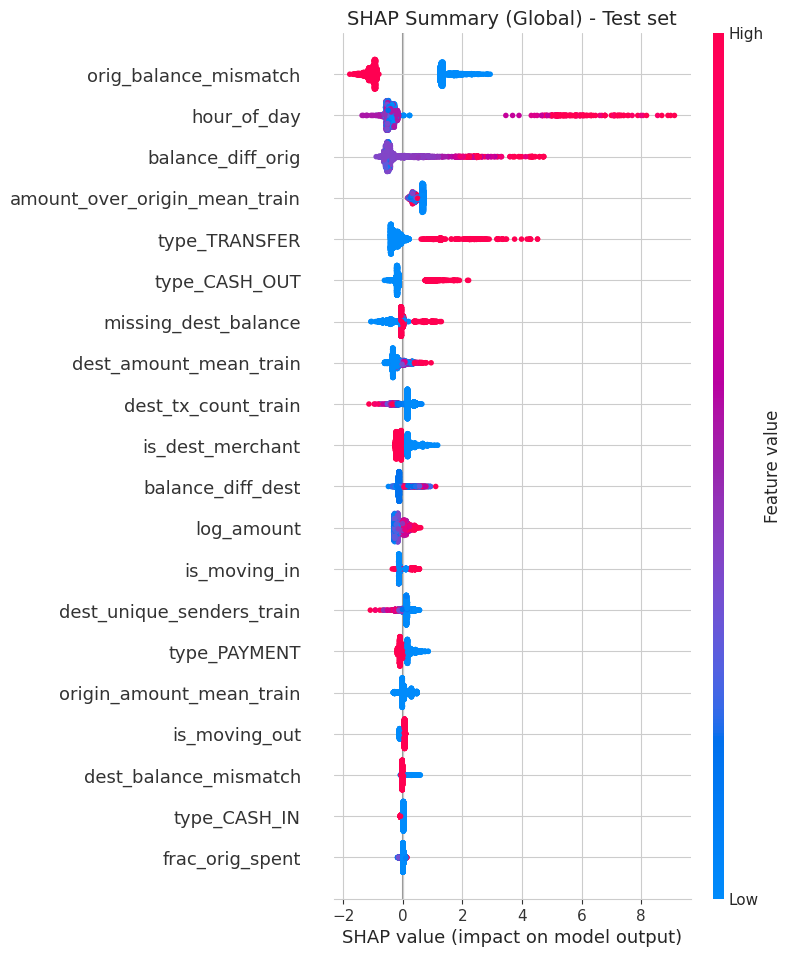

In [29]:
# Prepare readable transformed feature names
try:
    num_names = numeric_feats
    cat_ohe_names = list(preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_feats)) if len(cat_feats) > 0 else []
    trans_feature_names = list(num_names) + list(cat_ohe_names)
except Exception:
    trans_feature_names = [f"f{i}" for i in range(X_test_trans.shape[1])]

# Compute SHAP values (TreeExplainer for tree models)
explainer = shap.TreeExplainer(base_clf)
shap_values = explainer.shap_values(X_test_trans)

# Global SHAP summary
shap.summary_plot(shap_values, X_test_trans, feature_names=trans_feature_names, show=False)
plt.title("SHAP Summary (Global) - Test set", fontsize=14)
plt.savefig("figures/shap_summary_test.png", dpi=200, bbox_inches='tight')
plt.show()




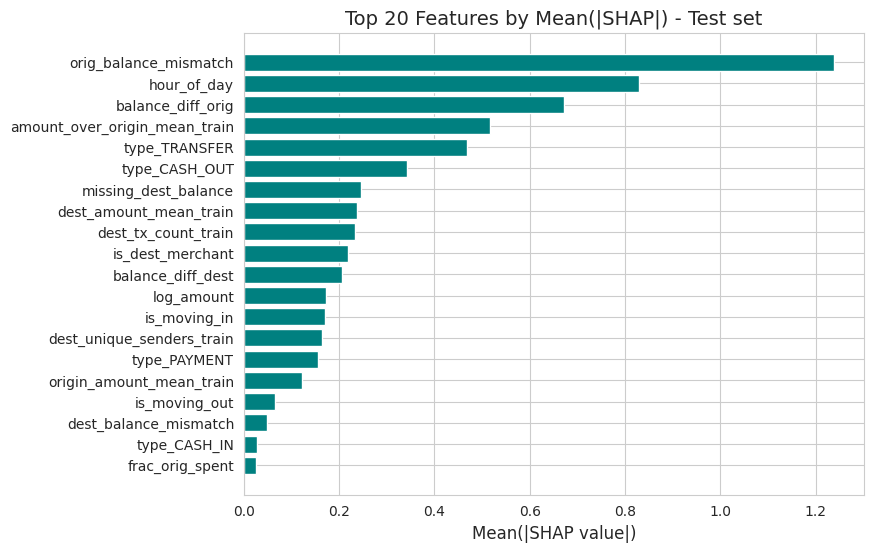

In [30]:
# Top 20 features by mean(|SHAP|)
shap_abs_mean = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(shap_abs_mean)[-20:]
top_names = [trans_feature_names[i] for i in top_idx]
top_vals = shap_abs_mean[top_idx]

plt.figure(figsize=(8,6))
plt.barh(top_names, top_vals, color='teal')
plt.title("Top 20 Features by Mean(|SHAP|) - Test set", fontsize=14)
plt.xlabel("Mean(|SHAP value|)", fontsize=12)
plt.savefig("figures/shap_top20.png", dpi=200, bbox_inches='tight')
plt.show()

In [31]:
# Use calibrated probabilities on test set and apply business threshold
test_proba = calibrator.predict_proba(X_test_trans)[:,1]
test_preds = (test_proba >= best_cost_t).astype(int)

print("Classification report (Test):")
print(classification_report(y_test, test_preds, digits=4))

tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("Confusion matrix (tn, fp, fn, tp):", (tn, fp, fn, tp))

roc = roc_auc_score(y_test, test_proba)
prec, rec, _ = precision_recall_curve(y_test, test_proba)
pr_auc = auc(rec, prec)
print(f"ROC-AUC: {roc:.4f}  |  PR-AUC: {pr_auc:.4f}")




Classification report (Test):
              precision    recall  f1-score   support

           0     0.9985    0.9930    0.9957      2001
           1     0.9414    0.9868    0.9636       228

    accuracy                         0.9924      2229
   macro avg     0.9700    0.9899    0.9797      2229
weighted avg     0.9927    0.9924    0.9925      2229

Confusion matrix (tn, fp, fn, tp): (np.int64(1987), np.int64(14), np.int64(3), np.int64(225))
ROC-AUC: 0.9975  |  PR-AUC: 0.9943


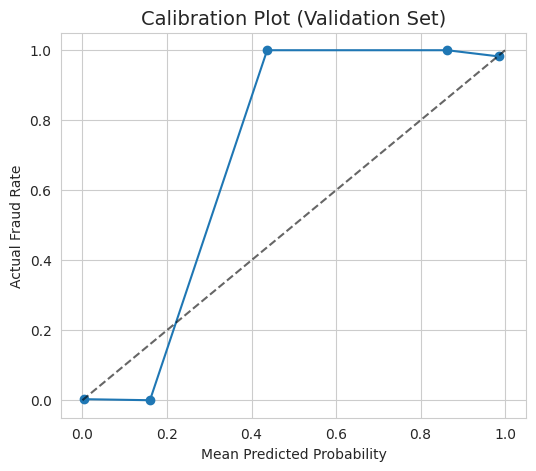

In [32]:
# AFTER MODELING, BEFORE FINAL BUSINESS EVALUATION
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_val, val_proba, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.title("Calibration Plot (Validation Set)", fontsize=14)
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Actual Fraud Rate")
plt.savefig("figures/calibration_plot.png", dpi=200, bbox_inches='tight')
plt.show()


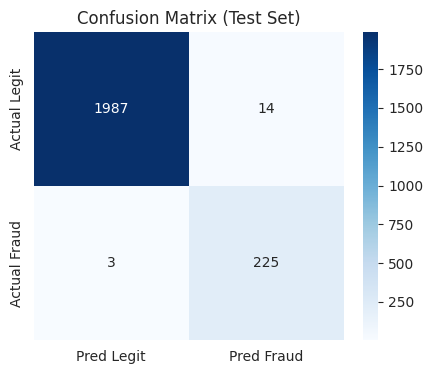

In [33]:

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, test_preds),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Legit','Pred Fraud'],
            yticklabels=['Actual Legit','Actual Fraud'])
plt.title("Confusion Matrix (Test Set)")
plt.savefig("figures/confusion_matrix_test.png", dpi=200)
plt.show()


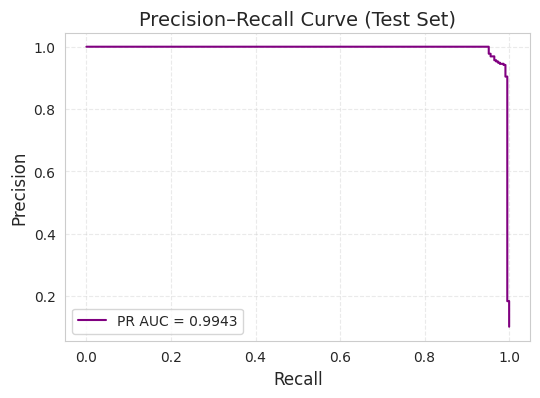

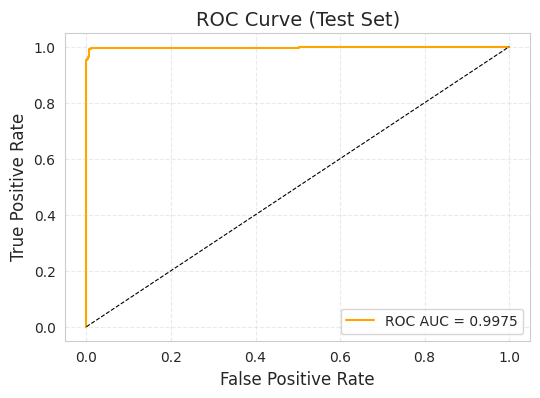

In [34]:
# Save PR & ROC curves
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.4f}', color='purple')
plt.title("Precision–Recall Curve (Test Set)", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("figures/pr_curve_test.png", dpi=200, bbox_inches='tight')
plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc:.4f}', color='orange')
plt.plot([0,1],[0,1], 'k--', linewidth=0.8)
plt.title("ROC Curve (Test Set)", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig("figures/roc_curve_test.png", dpi=200, bbox_inches='tight')
plt.show()


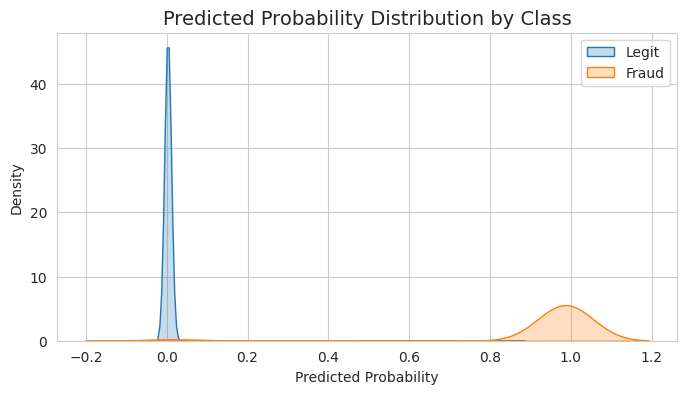

In [35]:
# FINAL BUSINESS IMPACT SECTION
plt.figure(figsize=(8,4))
sns.kdeplot(test_proba[y_test==0], label='Legit', fill=True)
sns.kdeplot(test_proba[y_test==1], label='Fraud', fill=True)
plt.title("Predicted Probability Distribution by Class", fontsize=14)
plt.xlabel("Predicted Probability")
plt.legend()
plt.savefig("figures/prob_distribution_by_class.png", dpi=200, bbox_inches='tight')
plt.show()


In [36]:
artifact = {
    'preprocessor': preprocessor,
    'model': base_clf,
    'calibrator': calibrator,
    'threshold': float(best_cost_t),
    'feature_names': feature_cols,
    'dest_agg_train': dest_agg_train,
    'orig_agg_train': orig_agg_train,
    'dest_unique_senders_train': dest_unique_senders_train,
    'orig_unique_dests_train': orig_unique_dests_train
}
joblib.dump(artifact, "fraud_model_artifact.pkl")
print("Saved artifact: fraud_model_artifact.pkl")

Saved artifact: fraud_model_artifact.pkl


In [37]:
import joblib
import pandas as pd
import numpy as np
import gradio as gr
import traceback

#Load artifact (preprocessor, model, calibrator, threshold, feature names, aggs) ----------
# This file was created by your training notebook: fraud_model_artifact_with_aggs.pkl
ARTIFACT_PATH = "fraud_model_artifact.pkl"
artifact = joblib.load(ARTIFACT_PATH)

preprocessor = artifact['preprocessor']        # ColumnTransformer pipeline
model = artifact['model']                      # trained classifier (XGBoost/CatBoost/other)
calibrator = artifact.get('calibrator', None)  # calibrated classifier (optional)
threshold = float(artifact.get('threshold', 0.5))
feature_cols = artifact['feature_names']       # feature order used in training

# Train-only aggs used for lookup at inference
dest_agg_train = artifact.get('dest_agg_train', pd.DataFrame())
orig_agg_train = artifact.get('orig_agg_train', pd.DataFrame())
dest_unique_senders_train = artifact.get('dest_unique_senders_train', pd.Series(dtype=int))
orig_unique_dests_train = artifact.get('orig_unique_dests_train', pd.Series(dtype=int))

# ---------- 2) Safe helpers ----------
def lookup_df(df, key, col):
    """Return df.loc[key, col] if exists, otherwise 0. Works with DataFrame index set to ID."""
    try:
        if key in df.index:
            return df.loc[key, col]
    except Exception:
        pass
    return 0

def lookup_series(series, key):
    """Return series[key] if exists, else 0."""
    try:
        if key in series.index:
            return series.loc[key]
    except Exception:
        pass
    return 0

def safe_float(x):
    """Convert to float or return 0.0 for invalid inputs."""
    try:
        return float(x)
    except Exception:
        return 0.0

# ---------- 3) Rule engine ----------
def apply_rules(row):
    """
    row: dict with keys amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, dest_tx_count_train, frac_orig_spent
    Returns list of textual flags. If list non-empty, we treat as high-confidence rule flag.
    """
    flags = []
    # Rule: impossible transfer (amount > old balance)
    if row['amount'] > row['oldbalanceOrg']:
        flags.append("Amount exceeds sender old balance (impossible)")

    # Rule: arithmetic mismatch on sender side
    if abs(row['oldbalanceOrg'] - row['amount'] - row['newbalanceOrig']) > 1e-2:
        flags.append("Sender balance arithmetic mismatch")

    # Rule: new destination (no history) receiving a large fraction of sender's balance
    if row.get('dest_tx_count_train', 0) == 0 and row['amount'] > 0.8 * max(1.0, row['oldbalanceOrg']):
        flags.append("New destination receiving unusually large transfer")

    # Rule: extreme fraction drained
    if row.get('frac_orig_spent', 0) >= 0.98:
        flags.append("Sender spending >=98% of balance")

    return flags

# ---------- 4) Robust hybrid predict (safe for Gradio) ----------
def hybrid_predict_safe(step, tx_type, amount,
                        nameOrig, oldbalanceOrg, newbalanceOrg,
                        nameDest, oldbalanceDest, newbalanceDest):
    """
    Inputs: raw transaction fields (UI collects these)
    Returns: tuple of strings for Gradio outputs: (rule_flags, ml_prob, ml_pred, final_pred, reason)
    """
    try:
        # --- 1. sanitize raw inputs ---
        amount = safe_float(amount)
        oldbalanceOrg = safe_float(oldbalanceOrg)
        newbalanceOrg = safe_float(newbalanceOrg)
        oldbalanceDest = safe_float(oldbalanceDest)
        newbalanceDest = safe_float(newbalanceDest)
        step = int(step) if step is not None else 0
        nameOrig = str(nameOrig).strip() if nameOrig is not None else ""
        nameDest = str(nameDest).strip() if nameDest is not None else ""
        tx_type = str(tx_type) if tx_type is not None else "TRANSFER"

        # --- 2. lookup train-only aggregations (0 if unseen) ---
        dest_tx_count = lookup_df(dest_agg_train, nameDest, 'dest_tx_count_train')
        dest_mean_amt = lookup_df(dest_agg_train, nameDest, 'dest_amount_mean_train')
        orig_tx_count = lookup_df(orig_agg_train, nameOrig, 'origin_tx_count_train')
        orig_mean_amt = lookup_df(orig_agg_train, nameOrig, 'origin_amount_mean_train')
        dest_unique = lookup_series(dest_unique_senders_train, nameDest)
        orig_unique = lookup_series(orig_unique_dests_train, nameOrig)

        # --- 3. compute internal engineered features ---
        log_amount = np.log1p(amount)
        hour_of_day = int(step) % 24
        frac_orig_spent = amount / (oldbalanceOrg + 1e-9)
        missing_dest_balance = 1 if oldbalanceDest == 0 else 0
        is_dest_merchant = 1 if nameDest.startswith("M") else 0
        balance_diff_orig = oldbalanceOrg - newbalanceOrg
        balance_diff_dest = newbalanceDest - oldbalanceDest
        orig_balance_mismatch = int(abs(oldbalanceOrg - amount - newbalanceOrg) > 1e-6)
        dest_balance_mismatch = int(abs(oldbalanceDest + amount - newbalanceDest) > 1e-6)
        is_moving_out = int(oldbalanceOrg > newbalanceOrg)
        is_moving_in = int(newbalanceDest > oldbalanceDest)
        amount_over_origin_mean = amount / (orig_mean_amt + 1e-9)

        # --- 4. construct feature dict exactly matching feature_cols ---
        feat = {c: 0.0 for c in feature_cols}  # defensive default
        # fill supported features
        mapping = {
            "log_amount": log_amount,
            "hour_of_day": hour_of_day,
            "frac_orig_spent": frac_orig_spent,
            "missing_dest_balance": missing_dest_balance,
            "is_dest_merchant": is_dest_merchant,
            "balance_diff_orig": balance_diff_orig,
            "balance_diff_dest": balance_diff_dest,
            "orig_balance_mismatch": orig_balance_mismatch,
            "dest_balance_mismatch": dest_balance_mismatch,
            "is_moving_out": is_moving_out,
            "is_moving_in": is_moving_in,
            "dest_tx_count_train": dest_tx_count,
            "dest_amount_mean_train": dest_mean_amt,
            "origin_tx_count_train": orig_tx_count,
            "origin_amount_mean_train": orig_mean_amt,
            "dest_unique_senders_train": dest_unique,
            "orig_unique_dests_train": orig_unique,
            "amount_over_origin_mean_train": amount_over_origin_mean,
            "type": tx_type
        }
        for k, v in mapping.items():
            if k in feat:
                feat[k] = v

        X = pd.DataFrame([feat], columns=feature_cols)

        # --- 5. transform & predict (use calibrator if present) ---
        X_trans = preprocessor.transform(X)  # preprocessor was fitted during training
        if calibrator is not None and hasattr(calibrator, "predict_proba"):
            prob = calibrator.predict_proba(X_trans)[0, 1]
        else:
            # fallback to raw model probabilities
            prob = model.predict_proba(X_trans)[0, 1]

        ml_pred = 1 if prob >= threshold else 0

        # --- 6. apply rule engine and decide final output ---
        rule_input = {
            'amount': amount,
            'oldbalanceOrg': oldbalanceOrg,
            'newbalanceOrig': newbalanceOrg,
            'oldbalanceDest': oldbalanceDest,
            'newbalanceDest': newbalanceDest,
            'dest_tx_count_train': dest_tx_count,
            'frac_orig_spent': frac_orig_spent
        }
        rules = apply_rules(rule_input)
        if len(rules) > 0:
            final_pred = 1
            reason = "Rule-based override"
        else:
            final_pred = ml_pred
            reason = "ML-based decision"

        # --- 7. human-friendly risk label ---
        if prob >= 0.80:
            risk_label = f"🔴 HIGH RISK ({prob:.3f})"
        elif prob >= 0.40:
            risk_label = f"🟠 MEDIUM RISK ({prob:.3f})"
        else:
            risk_label = f"🟢 LOW RISK ({prob:.3f})"

        # --- 8. return values (strings for Gradio)
        notes = f"dest_tx_count={dest_tx_count}, origin_tx_count={orig_tx_count}, amount_over_origin_mean={amount_over_origin_mean:.3f}"
        return ("\n".join(rules) if rules else "No rule violations",
                risk_label,
                f"{prob:.4f}",
                str(ml_pred),
                str(final_pred),
                reason,
                notes)

    except Exception as e:
        tb = traceback.format_exc()
        # return visible error in Gradio instead of crash
        return ("ERROR", f"{str(e)[:200]}", tb[:1000], "", "", "", "")

# ---------- 5) Build Gradio UI (minimal, clean, production-like) ----------
iface = gr.Interface(
    fn=hybrid_predict_safe,
    inputs=[
        gr.Number(label="Step (Time)", value=0),
        gr.Dropdown(["CASH_IN","CASH_OUT","DEBIT","PAYMENT","TRANSFER"], label="Type"),
        gr.Number(label="Amount", value=0.0),
        gr.Textbox(label="Sender ID (nameOrig)"),
        gr.Number(label="Sender Old Balance", value=0.0),
        gr.Number(label="Sender New Balance", value=0.0),
        gr.Textbox(label="Receiver ID (nameDest)"),
        gr.Number(label="Receiver Old Balance", value=0.0),
        gr.Number(label="Receiver New Balance", value=0.0),
    ],
    outputs=[
       gr.Textbox(label="Rule-based Flags"),
        gr.Textbox(label="Risk Level"),
        gr.Textbox(label="ML Probability"),
        gr.Textbox(label="ML Prediction (1=Fraud)"),
        gr.Textbox(label="Final Decision (1=Fraud)"),
        gr.Textbox(label="Decision Reason"),
        gr.Textbox(label="Notes (internal features)")
    ],
    title="Fraud Detection System",
    description="Enter raw transaction fields only. Aggregations and engineered features are computed internally using training-history stored in artifact."
)

# To run:
# iface.launch(share=True)   # in Colab, share=True gives a public link
iface.launch()             # in local notebook


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3fcfe65f354dcfd901.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [38]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,hour_of_day,frac_orig_spent,missing_dest_balance,is_dest_merchant,balance_diff_orig,balance_diff_dest,orig_balance_mismatch,dest_balance_mismatch,is_moving_out,is_moving_in
0,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,...,1,1.000000,1,0,181.00,0.00,0,1,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,...,1,1.000000,0,0,181.00,-21182.00,0,1,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,...,1,1.000000,1,0,2806.00,0.00,0,1,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,...,1,1.000000,0,0,2806.00,-26202.00,0,1,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,...,1,1.000000,1,0,20128.00,0.00,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11137,7,DEBIT,6393.71,C1331144930,433084.38,426690.68,C684896216,478421.00,210535.25,0,...,7,0.014763,0,0,6393.70,-267885.75,1,1,1,0
11138,7,CASH_OUT,298799.54,C932023579,426690.68,127891.14,C1761353343,704355.36,5270364.19,0,...,7,0.700272,0,0,298799.54,4566008.83,0,1,1,1
11139,7,CASH_OUT,423159.63,C61395726,127891.14,0.00,C1298316171,610479.00,749621.53,0,...,7,3.308749,0,0,127891.14,139142.53,1,1,1,1
11140,7,PAYMENT,1094.03,C1224570697,13918.00,12823.97,M983553548,0.00,0.00,0,...,7,0.078605,1,1,1094.03,0.00,0,1,1,0


In [39]:
# ================================
# CORE EXPORT CELL FOR POWER BI
# ================================

import os
import numpy as np
import pandas as pd
import hashlib
from datetime import datetime

# --------------------------------
# OUTPUT FOLDER
# --------------------------------
os.makedirs("data", exist_ok=True)

# --------------------------------
# CREATE A STABLE tx_id FOR JOINS
# --------------------------------
def make_tx_id(row):
    base = f"{row['step']}_{row['nameOrig']}_{row['nameDest']}_{row['amount']}"
    return hashlib.md5(base.encode()).hexdigest()

df["tx_id"] = df.apply(make_tx_id, axis=1)
X_test["tx_id"] = X_test.apply(make_tx_id, axis=1)

# ================================
# 1) TRANSACTIONS CLEAN
# ================================
df_export = df.copy()

cols_keep = ['tx_id','step','type','amount','log_amount','hour_of_day',
             'nameOrig','nameDest',
             'oldbalanceOrg','newbalanceOrig',
             'oldbalanceDest','newbalanceDest',
             'isFraud','frac_orig_spent','missing_dest_balance',
             'is_dest_merchant','balance_diff_orig','balance_diff_dest',
             'orig_balance_mismatch','dest_balance_mismatch',
             'is_moving_out','is_moving_in']

df_export = df_export[[c for c in cols_keep if c in df_export.columns]]
df_export.to_csv("data/transactions_clean.csv", index=False)
print("✅ transactions_clean.csv exported")

# ================================
# 2) MODEL PREDICTIONS
# ================================
test_df = X_test.copy()
test_df["tx_id"] = X_test["tx_id"]
test_df["isFraud"] = y_test.values
test_df["pred_proba"] = test_proba
test_df["pred_label"] = test_preds

keep = ['tx_id','step','type','amount','log_amount','hour_of_day',
        'nameOrig','nameDest','pred_proba','pred_label',
        'isFraud','frac_orig_spent','dest_tx_count_train',
        'origin_tx_count_train','amount_over_origin_mean_train',
        'missing_dest_balance']

test_df = test_df[[c for c in keep if c in test_df.columns]]
test_df.to_csv("data/model_predictions.csv", index=False)
print("✅ model_predictions.csv exported")

# ================================
# 3) AGG BY TRANSACTION TYPE
# ================================
agg_type = df.groupby("type").agg(
    total_tx=("amount","count"),
    total_fraud=("isFraud","sum"),
    fraud_rate=("isFraud","mean"),
    avg_amount=("amount","mean"),
    median_amount=("amount","median")
).reset_index()

agg_type.to_csv("data/agg_by_type.csv", index=False)
print("✅ agg_by_type.csv exported")

# ================================
# 4) FRAUD BY HOUR HEATMAP
# ================================
hb = df.pivot_table(index="hour_of_day",
                    columns="type",
                    values="isFraud",
                    aggfunc="mean").reset_index()

hb.to_csv("data/fraud_by_hour.csv", index=False)
print("✅ fraud_by_hour.csv exported")

# ================================
# 5) SHAP TOP FEATURES
# ================================
shap_abs_mean = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": trans_feature_names,
    "mean_abs_shap": shap_abs_mean
}).sort_values("mean_abs_shap", ascending=False).head(20)

shap_df.to_csv("data/shap_values_top.csv", index=False)
print("✅ shap_values_top.csv exported")

# ================================
# 6) LIVE ALERTS SAMPLE
# ================================
alerts = test_df[test_df["pred_proba"] >= 0.6].copy().reset_index(drop=True)

alerts["alert_time"] = pd.Timestamp.now().normalize() + pd.to_timedelta(alerts["hour_of_day"], unit="h")

def severity_map(x):
    if x >= 0.8: return "High"
    if x >= 0.6: return "Medium"
    return "Low"

alerts["severity"] = alerts["pred_proba"].apply(severity_map)
alerts.to_csv("data/alerts_live_sample.csv", index=False)
print("✅ alerts_live_sample.csv exported")

# ================================
# 7) ROC & PR EXPORT (OPTIONAL)
# ================================
try:
    pd.DataFrame({"fpr": fpr, "tpr": tpr}).to_csv("data/roc_points.csv", index=False)
    pd.DataFrame({"recall": rec, "precision": prec}).to_csv("data/pr_points.csv", index=False)
    print("✅ ROC and PR curve files exported")
except:
    print("⚠️ ROC/PR arrays not found — skipping curve export")

# ================================
# SUMMARY
# ================================
print("\n🎯 POWER BI EXPORT COMPLETE")
print("Files created in /data folder:")
for f in os.listdir("data"):
    print(" -", f)


✅ transactions_clean.csv exported
✅ model_predictions.csv exported
✅ agg_by_type.csv exported
✅ fraud_by_hour.csv exported
✅ shap_values_top.csv exported
✅ alerts_live_sample.csv exported
✅ ROC and PR curve files exported

🎯 POWER BI EXPORT COMPLETE
Files created in /data folder:
 - alerts_live_sample.csv
 - model_predictions.csv
 - transactions_clean.csv
 - shap_values_top.csv
 - fraud_by_hour.csv
 - roc_points.csv
 - pr_points.csv
 - agg_by_type.csv
